In [1]:
from torch_geometric.datasets import NELL
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch

dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
# data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(GCN,self).__init__()    # 构造函数

        self.conv1 = GCNConv(in_channels=in_c, out_channels=hid_c)
        self.conv2 = GCNConv(in_channels=hid_c, out_channels=out_c)
  
    def forward(self, data):
        x, edge_index = data.x, data.edge_index    # x:节点特征矩阵; edge_index:COO格式的图形连接，维度[2,边的数量]，数据：[ [源节点],[目标节点] ]
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        
        x1 = F.log_softmax(x, dim=1)
        
        return x1, x

model = GCN(in_c=dataset.num_node_features,hid_c=100,out_c=dataset.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

print(model(data))

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out1, out = model(data)
    # 交叉熵损失
    loss = F.nll_loss(out1[data.train_mask], data.y[data.train_mask])       # 负对数似然。
    loss.backward()
    optimizer.step()
    print('epoch:',epoch, 'loss:',loss.item())  

print(out)

(tensor([[-3.5694, -3.5350, -3.4424,  ..., -3.4999, -3.5030, -3.5552],
        [-3.5675, -3.5345, -3.4692,  ..., -3.4943, -3.4970, -3.5409],
        [-3.5549, -3.5613, -3.4735,  ..., -3.5040, -3.5179, -3.5502],
        ...,
        [-3.5349, -3.5582, -3.4964,  ..., -3.5137, -3.5456, -3.5494],
        [-3.5608, -3.5750, -3.4676,  ..., -3.5397, -3.5249, -3.5546],
        [-3.5770, -3.5796, -3.4526,  ..., -3.5344, -3.5357, -3.5546]],
       grad_fn=<LogSoftmaxBackward>), tensor([[-0.0406, -0.0062,  0.0864,  ...,  0.0289,  0.0258, -0.0264],
        [-0.0424, -0.0093,  0.0559,  ...,  0.0309,  0.0281, -0.0158],
        [-0.0293, -0.0357,  0.0520,  ...,  0.0216,  0.0077, -0.0247],
        ...,
        [-0.0082, -0.0316,  0.0303,  ...,  0.0129, -0.0190, -0.0228],
        [-0.0308, -0.0449,  0.0625,  ..., -0.0096,  0.0051, -0.0246],
        [-0.0477, -0.0503,  0.0766,  ..., -0.0051, -0.0064, -0.0253]],
       grad_fn=<AddBackward0>))
epoch: 0 loss: 3.517864227294922
epoch: 1 loss: 3.50494098663

epoch: 223 loss: 0.19734612107276917
epoch: 224 loss: 0.19499030709266663
epoch: 225 loss: 0.19267234206199646
epoch: 226 loss: 0.19038952887058258
epoch: 227 loss: 0.188144713640213
epoch: 228 loss: 0.18593531847000122
epoch: 229 loss: 0.18376097083091736
epoch: 230 loss: 0.18162105977535248
epoch: 231 loss: 0.1795162558555603
epoch: 232 loss: 0.17744645476341248
epoch: 233 loss: 0.17540927231311798
epoch: 234 loss: 0.173405259847641
epoch: 235 loss: 0.17143326997756958
epoch: 236 loss: 0.16949467360973358
epoch: 237 loss: 0.16758567094802856
epoch: 238 loss: 0.16570618748664856
epoch: 239 loss: 0.16385763883590698
epoch: 240 loss: 0.16203781962394714
epoch: 241 loss: 0.1602514684200287
epoch: 242 loss: 0.15849155187606812
epoch: 243 loss: 0.15676215291023254
epoch: 244 loss: 0.1550593376159668
epoch: 245 loss: 0.15338343381881714
epoch: 246 loss: 0.15173554420471191
epoch: 247 loss: 0.15011201798915863
epoch: 248 loss: 0.14851294457912445
epoch: 249 loss: 0.14693906903266907
epoch: 2

epoch: 457 loss: 0.035480767488479614
epoch: 458 loss: 0.0353296734392643
epoch: 459 loss: 0.03517981618642807
epoch: 460 loss: 0.03503115847706795
epoch: 461 loss: 0.03488367423415184
epoch: 462 loss: 0.03473738580942154
epoch: 463 loss: 0.03459247946739197
epoch: 464 loss: 0.03444845229387283
epoch: 465 loss: 0.03430569916963577
epoch: 466 loss: 0.03416384011507034
epoch: 467 loss: 0.03402356803417206
epoch: 468 loss: 0.0338841937482357
epoch: 469 loss: 0.03374551981687546
epoch: 470 loss: 0.033608149737119675
epoch: 471 loss: 0.033471930772066116
epoch: 472 loss: 0.03333700820803642
epoch: 473 loss: 0.03320275992155075
epoch: 474 loss: 0.033070001751184464
epoch: 475 loss: 0.03293789178133011
epoch: 476 loss: 0.03280674293637276
epoch: 477 loss: 0.03267660737037659
epoch: 478 loss: 0.032547738403081894
epoch: 479 loss: 0.03241991624236107
epoch: 480 loss: 0.032292690128088
epoch: 481 loss: 0.03216669335961342
epoch: 482 loss: 0.03204142674803734
epoch: 483 loss: 0.03191746398806572


In [3]:
import pandas as pd
from sklearn import cluster
from sklearn import metrics

out=out.cpu().detach().numpy()
model = cluster.KMeans(n_clusters=4)
model.fit(out)

y_predict = model.predict(out)

# Calinski-Harabaz Index：越大越好
# Silhouette Coefficient：轮廓系数（越大越好)
print('Calinski-Harabaz Index：',metrics.calinski_harabasz_score(out,y_predict))
print('Silhouette Coefficient：',metrics.silhouette_score(out,y_predict))



Calinski-Harabaz Index： 34.85395874702531
Silhouette Coefficient： 0.4443395


In [21]:
from sklearn.manifold import TSNE
t_sne = TSNE()
data=t_sne.fit_transform(out)
data=pd.DataFrame(data)
data = pd.DataFrame(data,index=y_predict)
data_tsne = pd.DataFrame(t_sne.embedding_, index =y_predict)
data_tsne

,0,1
2,221.331146,-72.517181
2,-62.793858,176.965225
2,168.154343,-17.605772
3,120.997375,24.414715
0,-76.015686,-12.484374
0,-149.220886,-114.855545
0,-67.272942,52.500839
1,-21.159119,-108.043968
1,-22.462019,106.347786
1,39.575966,-66.707489


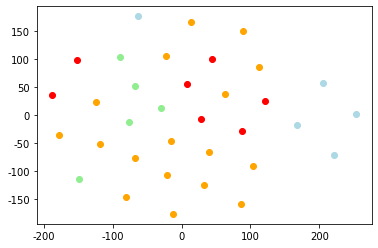

In [23]:
from matplotlib import pyplot as plt
d = data_tsne[data_tsne.index == 0]     #找出聚类类别为0的数据对应的降维结果
plt.scatter(d[0], d[1],c='lightgreen',marker='o')
d = data_tsne[data_tsne.index == 1]
plt.scatter(d[0], d[1], c='orange',	marker='o')
d = data_tsne[data_tsne.index == 2]
plt.scatter(d[0], d[1], c='lightblue',marker='o')
d = data_tsne[data_tsne.index == 3]
plt.scatter(d[0], d[1], c='red',marker='o')